In [79]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

pd.set_option('display.max_columns', None)

In [80]:
train_df = pd.read_csv("project/data/train/features.csv", parse_dates = ['date_recorded' ],  na_values = [0, '0'])
labels = pd.read_csv("project/data/train/labels.csv")

test_df = pd.read_csv("project/data/test/test.csv", parse_dates = ['date_recorded' ],  na_values = [0, '0'])

# Merge features and labels files
train_df = pd.merge(labels, train_df, on='id')

print("Numerical columns: \n", train_df.select_dtypes(include=np.number).columns.tolist())

Numerical columns: 
 ['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year']


In [81]:
# Impute values based on subvillage or ward if available

#create mean on the lowest granularity level (subvillage)
means_population_subvillage = train_df.groupby(['subvillage'])['population'].mean().reset_index()#
print(means_population_subvillage)
means_population_subvillage = means_population_subvillage.rename(columns={"population": "population_imputed_subvillage"})

# #ward level
means_population_ward = train_df.groupby(['ward',])['population'].mean().reset_index()
means_population_ward = means_population_ward.rename(columns={"population": "population_imputed_ward"})

# #lga level
# means_population_lga = train_df.groupby(['region', 'lga'])['population'].mean().reset_index()
# means_population_lga = means_population_lga .rename(columns={"population": "population_imputed_lga"})

#merge the aggregated dataframes as new columns to the original df
train_df = train_df.merge(means_population_subvillage, how = 'left', on = ['subvillage'])
train_df = train_df.merge(means_population_ward, how = 'left', on = ['ward'])
# train_df = train_df.merge(means_population_lga, how = 'left', on = ['region', 'lga'])


#create final imputed longitude column
train_df['imputed_population'] = np.where(train_df['population'].isna(), train_df['population_imputed_subvillage'], train_df['population']) #if longitude is missing, impute it by the mean of the subvillage
train_df['imputed_population'] = np.where(train_df['imputed_population'].isna(), train_df['population_imputed_ward'], train_df['imputed_population']) #if subvillage mean is missing, impute it by the ward
# train_df['imputed_population'] = np.where(train_df['imputed_population'].isna(), train_df['population_imputed_lga'], train_df['imputed_population'])
# #drop redundant columns
train_df = train_df.drop(['population_imputed_subvillage'], axis=1)

              subvillage   population
0                     ##          NaN
1               'A' Kati   250.000000
2                      1   860.769231
3            14Kambalage          NaN
4                     18          NaN
...                  ...          ...
19282  Zumbawanu Shuleni          NaN
19283              Zunga   100.000000
19284            Zunguni  1000.000000
19285            Zunzuli          NaN
19286               Zuri          NaN

[19287 rows x 2 columns]


C:\Users\adamw\AppData\Local\Temp\ipykernel_17588\86439571.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot( train_df['imputed_population'], color = '#66c2a5')


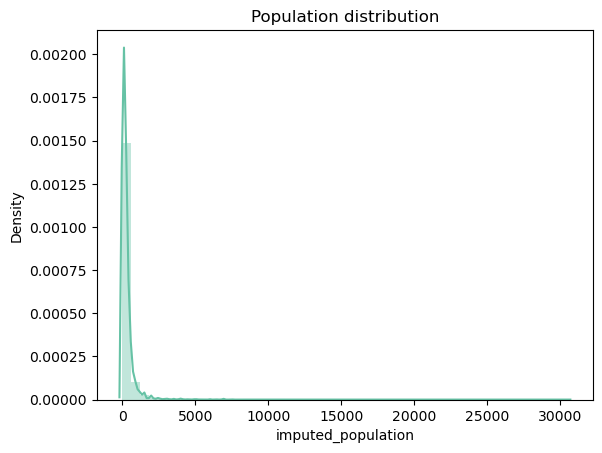

In [82]:
# Do binning of populations

# Print distribution of population
ax = sns.distplot( train_df['imputed_population'], color = '#66c2a5')
ax.set(title = 'Population distribution')
plt.show()


In [83]:
bin_thresh = []

print(train_df.loc[train_df["population"].isna() == True, "subvillage"].isna().value_counts())

print(train_df["imputed_population"].isna().value_counts())
print(train_df["population"].isna().value_counts())

# Calculate mean, excluding large values
# temp = train_df["imputed_population"].isna().value_counts()

# temp

False    21019
True       361
Name: subvillage, dtype: int64
False    43816
True     15583
Name: imputed_population, dtype: int64
False    38019
True     21380
Name: population, dtype: int64
